https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction/comments

https://www.kaggle.com/code/mgmarques/wines-type-and-quality-classification-exercises#notebook-container

https://www.kaggle.com/code/vishalyo990/prediction-of-quality-of-wine

https://www.kaggle.com/code/henriqueyamahata/bank-marketing-classification-roc-f1-recall

# Data Preparation

In [2]:
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import skew, norm, probplot, boxcox, f_oneway

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, f1_score, precision_score,recall_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV

## Load Dataset





https://archive.ics.uci.edu/ml/datasets/Bank+Marketing



In [3]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df['target'] = df['y'].apply(lambda x : 1 if x=='yes' else 0)


In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0


<AxesSubplot:xlabel='y', ylabel='Count'>

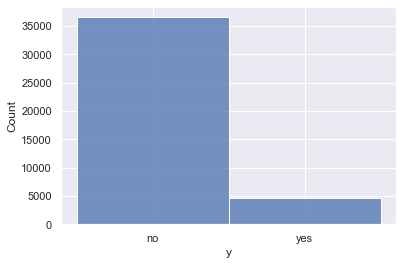

In [5]:
sns.set(style="darkgrid")
sns.histplot(df['y'], discrete=True)

In [6]:
df[df['y']=='yes'].shape[0]/df[df['y']=='no'].shape[0]

0.126956331399803

In [7]:
df = df.drop(['y'], axis=1)

In [8]:
X_cols = df.columns[:-1]

## Exploratory Data Analysis

In [9]:
def data_check(df):
    data_types = df.dtypes
    nrows = df.shape[0]
    nnulls = df.isnull().sum()
    null_ratio = nnulls/nrows * 100
    skewness = df.skew()
    
    out = pd.concat([data_types, nnulls, null_ratio, skewness], axis = 1)
    out.columns = ['dtypes', 'num_nulls', 'null_ratio_pct', 'skewness']
    return out

In [10]:
data_check_out = data_check(df)
data_check_out

,dtypes,num_nulls,null_ratio_pct,skewness
age,int64,0,0.0,0.784697
job,object,0,0.0,NaN
marital,object,0,0.0,NaN
education,object,0,0.0,NaN
default,object,0,0.0,NaN
housing,object,0,0.0,NaN
loan,object,0,0.0,NaN
contact,object,0,0.0,NaN
month,object,0,0.0,NaN
day_of_week,object,0,0.0,NaN


In [11]:
# get list of numeric variables
numeric_vars = data_check_out[data_check_out['dtypes']!='object'].index
cat_vars = data_check_out[data_check_out['dtypes']=='object'].index

### Correlation

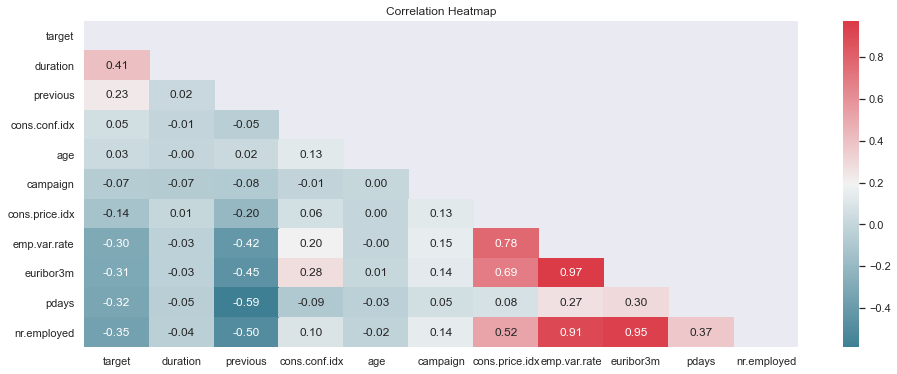

In [12]:
plt.figure(figsize=(16, 6))
corr = df.corr()
top_corr_cols = corr.target.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
heatmap = sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap')
sns.set(font_scale=1)
del corr, dropSelf, top_corr

In [13]:
print(len(df.columns))
print(len(numeric_vars))
print(len(cat_vars))
cols = df.columns

21
11
10


In [14]:
print(numeric_vars)

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'target'],
      dtype='object')


### Check Distribution

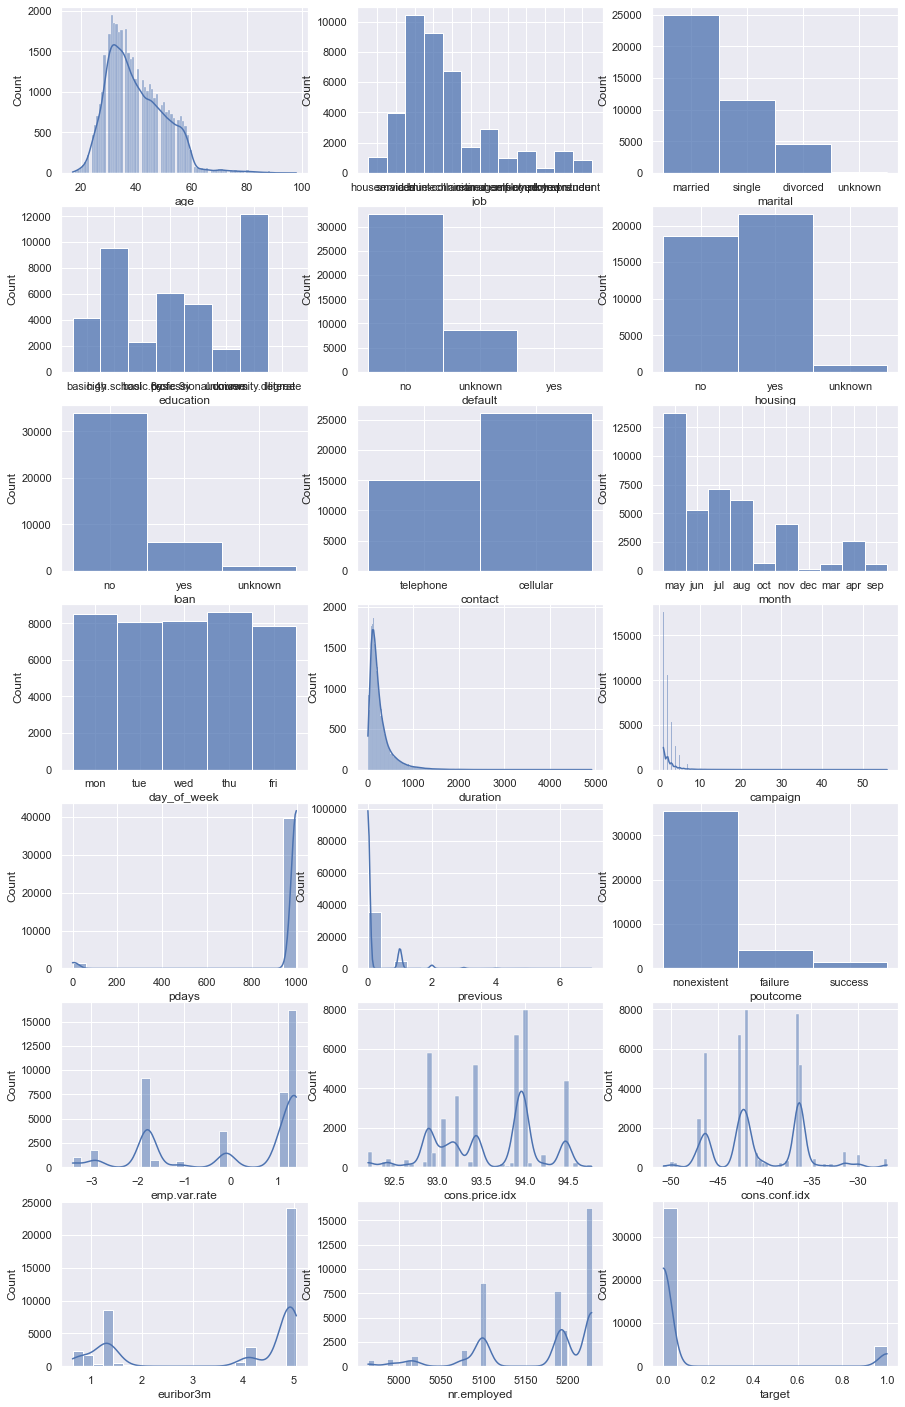

In [15]:
fig, axs = plt.subplots(7, 3, figsize=(15, 25))
for i in range(7):
    for j in range(3):
        try:
            if cols[i*3+j] in numeric_vars:
                sns.histplot(df[cols[i*3+j]], ax = axs[i,j], kde=True)
            else:
                sns.histplot(df[cols[i*3+j]], ax = axs[i,j])
        except:
            continue

In [16]:
# Box Cox
high_skew_data = data_check_out['skewness'][numeric_vars].abs().sort_values()[-4:]
high_skew_data

duration    3.263141
previous    3.832042
campaign    4.762507
pdays       4.922190
Name: skewness, dtype: float64

In [17]:
l_opt = {}
for col in ['duration']:
    df[col], l_opt[col] = boxcox(df[col]+1)

In [18]:
# # Skewness after boxcox transform
# df[high_skew_data.index].skew()

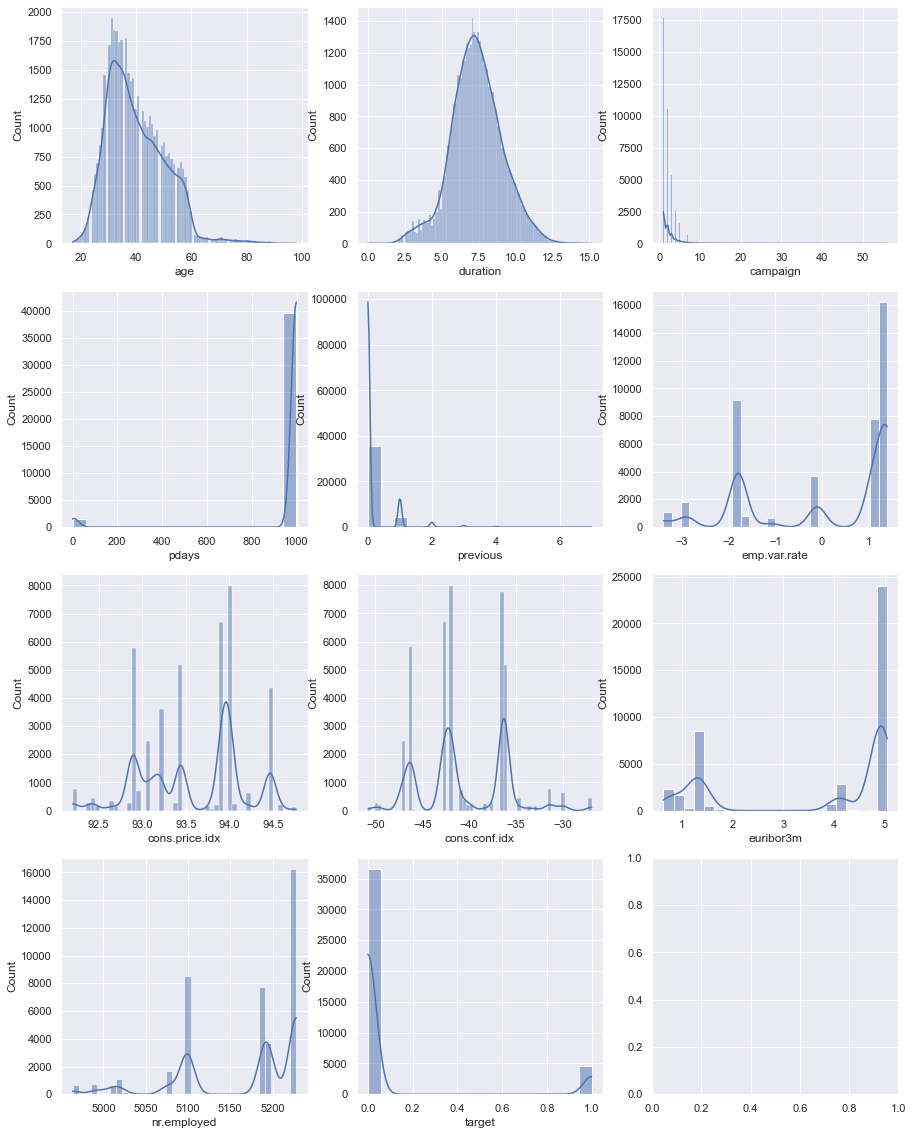

In [19]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
for i in range(4):
    for j in range(3):
        try:
            sns.histplot(df[numeric_vars[i*3+j]], ax = axs[i,j], kde=True)
        except:
            continue

## Categorical Transformation

In [20]:
print(cat_vars)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')


In [21]:
labelencoder = LabelEncoder()

for c in cat_vars:
    df[c] = labelencoder.fit_transform(df[c]) 

## Standardization

In [22]:
scaler = StandardScaler(with_std = False)
df_std = pd.DataFrame(scaler.fit_transform(df[X_cols]), columns= X_cols) 

### Check Multicolinearity

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# the independent variables set

def calc_VIF(df, X_cols):

    X = df[X_cols]

    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]

    return vif_data.sort_values('VIF')

In [24]:
vif = calc_VIF(df_std, X_cols)
print(vif)

           feature        VIF
6             loan   1.002586
9      day_of_week   1.011267
5          housing   1.012338
1              job   1.022850
10        duration   1.046912
11        campaign   1.065362
3        education   1.097149
4          default   1.111675
2          marital   1.200580
0              age   1.253848
8            month   1.820008
7          contact   2.329254
17   cons.conf.idx   3.571236
14        poutcome   4.515654
13        previous   5.323599
12           pdays   6.035383
16  cons.price.idx   9.666489
19     nr.employed  42.956435
15    emp.var.rate  43.367342
18       euribor3m  95.701095


In [25]:
X_cols_clean = [x for x in X_cols if x not in ['euribor3m', 'nr.employed']]

In [26]:
vif = calc_VIF(df_std, X_cols_clean)

In [27]:
print(vif)

           feature       VIF
6             loan  1.002557
9      day_of_week  1.010923
5          housing  1.011182
1              job  1.022182
10        duration  1.046400
11        campaign  1.060360
3        education  1.094889
4          default  1.109080
2          marital  1.200215
8            month  1.230707
0              age  1.251072
17   cons.conf.idx  1.320534
7          contact  2.096282
15    emp.var.rate  3.909129
16  cons.price.idx  4.265311
14        poutcome  4.484191
13        previous  5.225375
12           pdays  6.018588


# Modeling

- Decision trees with some form of pruning
- Neural networks
- Boosting
- Support Vector Machines
- k-nearest neighbors

In [62]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    
#     fig = plt.figure()
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # plotting learning curve
    
    
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    
    plt.fill_between(
            train_sizes,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="g",
        )
    plt.plot(
            train_sizes, train_scores_mean, "o-", color="r", label="Training score"
        )
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    plt.legend(loc="best")
    
    plt.grid()
    
    return plt
    

## Train Test Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_std[X_cols], df['target'], test_size=0.3, random_state=0)

In [70]:
X = df_std[X_cols]
y = df['target']

## Decision Tree Classifier

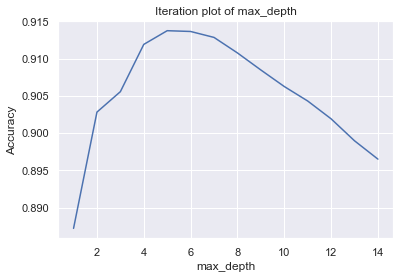

In [158]:
# Hyper-parameter Tuning
# max_depth
avg_acc_list = []
train_score_list = []
for i in range(1,15):
    dt = DecisionTreeClassifier(random_state=0, max_depth = i)
    avg_acc_list.append(np.mean(cross_val_score(dt, X_train, y_train, cv=5)))
    train_score_list.append(dt.fit(X_train, y_train).score(X_train, y_train))
    
plt.plot([i for i in range(1,15)], avg_acc_list)
# plt.plot([i for i in range(1,15)], train_score_list)
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title('Iteration plot of max_depth')
plt.show()

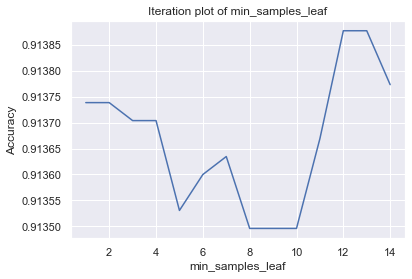

In [160]:
# min_samples_leaf
avg_acc_list = []
train_score_list = []
for i in range(1,15):
    dt = DecisionTreeClassifier(random_state=0, min_samples_leaf = i, max_depth=5)
    avg_acc_list.append(np.mean(cross_val_score(dt, X_train, y_train, cv=5)))
    train_score_list.append(dt.fit(X_train, y_train).score(X_train, y_train))
    
fig = plt.figure()
plt.plot([i for i in range(1,15)], avg_acc_list)
# plt.plot([i for i in range(1,15)], train_score_list)
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.title('Iteration plot of min_samples_leaf')
plt.show()

In [33]:
%%time
dt = DecisionTreeClassifier(random_state=0)
param_grid = {'max_depth':[4,5,6,7,8], 'min_samples_leaf':[2,3,4,12,13]}
gs = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
CPU times: user 514 ms, sys: 227 ms, total: 741 ms
Wall time: 3.44 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'min_samples_leaf': [2, 3, 4, 12, 13]},
             scoring='accuracy', verbose=1)

In [38]:
gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 12}

In [30]:
%%time
dt = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_leaf=12)
np.mean(cross_val_score(dt, X_train, y_train, cv=5))
dt.fit(X_train, y_train)
# cross_validate(dt, X_train, y_train, cv=5, scoring=['accuracy', 'roc_auc'])

CPU times: user 255 ms, sys: 16 ms, total: 271 ms
Wall time: 276 ms


DecisionTreeClassifier(max_depth=5, min_samples_leaf=12, random_state=0)

In [55]:
%%time
out = dt.predict(X_test)

CPU times: user 6.37 ms, sys: 8.64 ms, total: 15 ms
Wall time: 12.5 ms


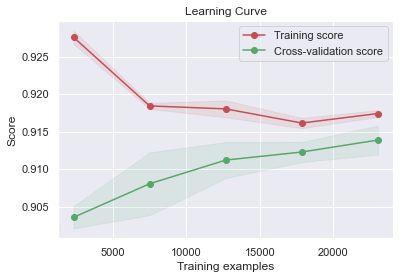

In [75]:
title = 'Learning Curve'
plot = plot_learning_curve(
    dt,
    title,
    X_train,
    y_train,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
)
plt.grid()
plt.title('Learning Curve')
plot.show()

In [60]:
np.linspace(0.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

## Neural Network

In [168]:
%%time
mlp = MLPClassifier(random_state = 0)
mlp.fit(X_train, y_train)
# np.mean(cross_val_score(mlp, X_train, y_train, cv=5))

CPU times: user 9.86 s, sys: 2.18 s, total: 12 s
Wall time: 1.69 s


MLPClassifier(random_state=0)

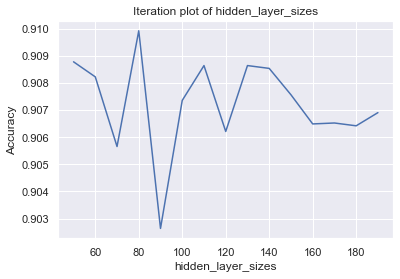

CPU times: user 24min 59s, sys: 5min 4s, total: 30min 4s
Wall time: 3min 59s


In [170]:
%%time
# hidden_layer_sizes
avg_acc_list = []
# fig = plt.figure(figsize=(10,8))
for i in range(50, 200, 10):

    mlp = MLPClassifier(random_state = 0, hidden_layer_sizes = i)
    mlp.fit(X_train, y_train)
#     plt.plot([x for x in range(len(mlp.loss_curve_))], mlp.loss_curve_, label = 'hidden_layer_size_'+str(i))
    avg_acc_list.append(np.mean(cross_val_score(mlp, X_train, y_train, cv=5)))
    
plt.plot([i for i in range(50, 200, 10)], avg_acc_list)
plt.xlabel("hidden_layer_sizes")
plt.ylabel("Accuracy")
plt.title('Iteration plot of hidden_layer_sizes')
# fig.legend(loc='upper right')
plt.show()

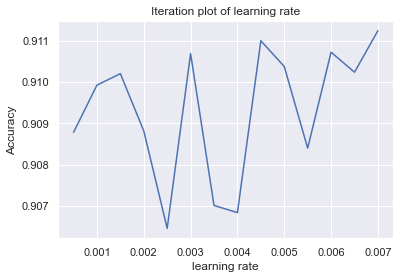

In [174]:
# learning_rate
avg_acc_list = []
for i in range(1, 15):
    mlp = MLPClassifier(random_state = 0, learning_rate_init = i*5/10000, hidden_layer_sizes=80)
#     mlp.fit(X_train, y_train)
#     plt.plot([x for x in range(len(mlp.loss_curve_))], mlp.loss_curve_, label = 'learning_rate'+str(i))
    avg_acc_list.append(np.mean(cross_val_score(mlp, X_train, y_train, cv=5)))
    
plt.plot([i*5/10000 for i in range(1, 15)], avg_acc_list)
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.title('Iteration plot of learning rate')
# fig.legend(loc='upper right')
plt.show()

In [44]:
%%time
mlp = MLPClassifier(random_state=0)
distributions = {'learning_rate_init':[r*5/10000 for r in range(1, 15)], 'hidden_layer_sizes':[l for l in range(80, 150, 10)]} 
rs = RandomizedSearchCV(mlp, distributions, random_state=0)
rs.fit(X_train, y_train)
rs.best_params_

CPU times: user 22min 31s, sys: 4min 52s, total: 27min 24s
Wall time: 3min 49s


{'learning_rate_init': 0.0015, 'hidden_layer_sizes': 80}

In [31]:
%%time
mlp = MLPClassifier(random_state=0, learning_rate_init=0.0045, hidden_layer_sizes=80, 
                    validation_fraction=0.2)
print(np.mean(cross_val_score(mlp, X_train, y_train, cv=5)))
mlp.fit(X_train, y_train)
# 0.910998606361346

0.910998606361346
CPU times: user 3min 31s, sys: 46 s, total: 4min 17s
Wall time: 36.5 s


MLPClassifier(hidden_layer_sizes=80, learning_rate_init=0.0045, random_state=0,
              validation_fraction=0.2)

Text(0.5, 1.0, 'Loss Curve')

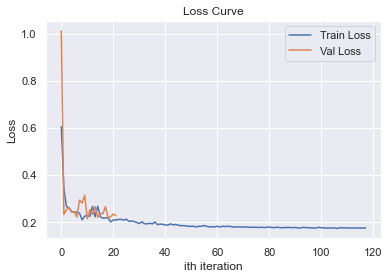

In [76]:
mlp.fit(X_train, y_train)
plt.plot(mlp.loss_curve_, label='Train Loss')
mlp.fit(X_test, y_test)
plt.plot(mlp.loss_curve_, label='Val Loss')
plt.legend()
plt.xlabel('ith iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')

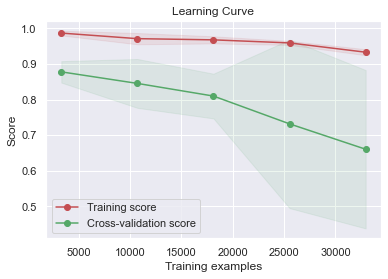

In [73]:
title = 'Learning Curve'
plot = plot_learning_curve(
    mlp,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=None,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
)
plt.grid()
plt.title('Learning Curve')
plot.show()

In [56]:
%%time
out = mlp.predict(X_test)

CPU times: user 36.8 ms, sys: 28.7 ms, total: 65.5 ms
Wall time: 23.5 ms


## Gradient Boosting

In [177]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                 max_depth=3, random_state=0)#.fit(X_train, y_train)
np.mean(cross_val_score(gbc, X_train, y_train, cv=5))

0.9154382455562319

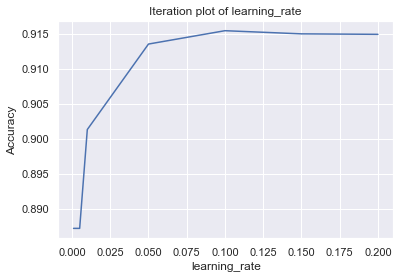

In [178]:
avg_acc_list = []
lr_list = [0.001,0.005,0.01,0.05,0.1, 0.15, 0.2]
for i in lr_list:
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=i, 
                                 max_depth=3, random_state=0)
    
    avg_acc_list.append(np.mean(cross_val_score(gbc, X_train, y_train, cv=5)))
    
plt.plot(lr_list, avg_acc_list)
plt.xlabel("learning_rate")
plt.ylabel("Accuracy")
plt.title('Iteration plot of learning_rate')
# fig.legend(loc='upper right')
plt.show()

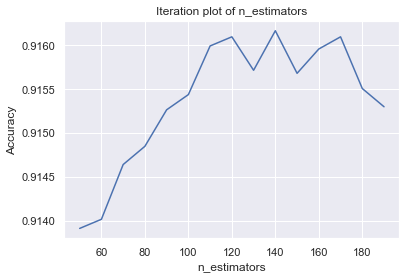

In [180]:
avg_acc_list = []
for i in range(50, 200, 10):
    gbc = GradientBoostingClassifier(n_estimators=i, learning_rate=0.1, 
                                 max_depth=3, random_state=0)
    
    avg_acc_list.append(np.mean(cross_val_score(gbc, X_train, y_train, cv=5)))
    
plt.plot([x for x in range(50,200,10)], avg_acc_list)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title('Iteration plot of n_estimators')
plt.show()

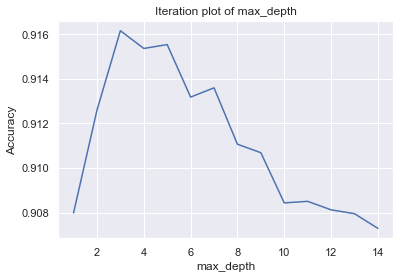

In [182]:
avg_acc_list = []
for i in range(1,15):
    gbc = GradientBoostingClassifier(n_estimators=140, learning_rate=0.1, 
                                 max_depth=i, random_state=0)
    
    avg_acc_list.append(np.mean(cross_val_score(gbc, X_train, y_train, cv=5)))
    
plt.plot([x for x in range(1,15)], avg_acc_list)
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title('Iteration plot of max_depth')
plt.show()

In [82]:
%%time
gbc = GradientBoostingClassifier(n_estimators=140, learning_rate=0.1, 
                                 max_depth=3, random_state=0).fit(X_train, y_train)

CPU times: user 3.61 s, sys: 18.4 ms, total: 3.62 s
Wall time: 3.62 s


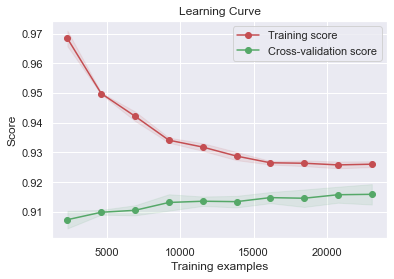

In [83]:
title = 'Learning Curve'
plot = plot_learning_curve(
    gbc,
    title,
    X_train,
    y_train,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 10),
)
plt.grid()
plt.title('Learning Curve')
plot.show()

In [57]:
%%time
gbc.predict(X_test)

CPU times: user 19.6 ms, sys: 6.35 ms, total: 26 ms
Wall time: 25.3 ms


array([0, 0, 0, ..., 0, 0, 1])

## Support Vector Machines

In [26]:
svm = SVC(gamma='auto', kernel = 'rbf')
np.mean(cross_val_score(svm, X_train, y_train, cv=5))

0.8982345579682647

In [28]:
avg_acc_dict = {}
for k in ['linear', 'rbf', 'sigmoid']:
    svm = SVC(gamma='auto', kernel = k)
    avg_acc_dict[k] = np.mean(cross_val_score(svm, X_train, y_train, cv=5))

In [49]:
avg_acc_dict

{'linear': 0.9078423104268601,
 'rbf': 0.8982345579682647,
 'sigmoid': 0.8729494201973613}

In [35]:
%%time
svm = SVC(gamma='auto', kernel = 'linear').fit(X_train, y_train)

CPU times: user 2min 29s, sys: 823 ms, total: 2min 30s
Wall time: 2min 31s


In [ ]:
title = 'Learning Curve'
plot = plot_learning_curve(
    svm,
    title,
    X_train,
    y_train,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
)
plt.grid()
plt.title('Learning Curve')
plot.show()

In [59]:
%%time
out = svm.predict(X_test)

CPU times: user 2.23 s, sys: 12.8 ms, total: 2.24 s
Wall time: 2.25 s


## KNN

In [51]:
knn = KNeighborsClassifier(n_neighbors=5)
np.mean(cross_val_score(knn, X_train, y_train, cv=5))

0.8977838492972051

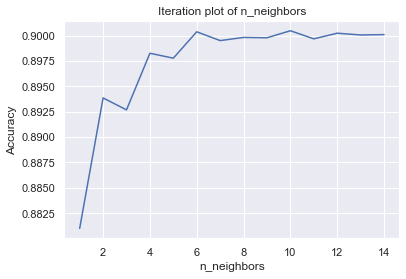

In [84]:
avg_acc_list = []
for i in range(1,15):
    knn = KNeighborsClassifier(n_neighbors=i)
    avg_acc_list.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    
plt.plot([x for x in range(1,15)], avg_acc_list)
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.title('Iteration plot of n_neighbors')
plt.show()

In [91]:
%%time
knn = KNeighborsClassifier(n_neighbors=6).fit(X_train, y_train)

CPU times: user 8.41 ms, sys: 3.97 ms, total: 12.4 ms
Wall time: 10.4 ms


In [ ]:
title = 'Learning Curve'
plot = plot_learning_curve(
    knn,
    title,
    X_train,
    y_train,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
)
plt.grid()
plt.title('Learning Curve')
plot.show()

In [92]:
%%time
out = knn.predict(X_test)

CPU times: user 8.38 s, sys: 3.67 s, total: 12 s
Wall time: 6 s


# Model Prediction

In [39]:
def get_metrics(y_true, y_pred):
    metrics = {}
    print('Accuracy:  {:2.2%} '.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:2.2%} '.format(precision_score(y_true, y_pred)))
    print('Recall:    {:2.2%} '.format(recall_score(y_true, y_pred)))
    print('F1 Score:  {:2.2%} '.format(f1_score(y_true, y_pred)))
    print('AUC Score: {:2.2%} '.format(roc_auc_score(y_true, y_pred)))
    
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['F1 Score'] = f1_score(y_true, y_pred)
    metrics['AUC Score'] = roc_auc_score(y_true, y_pred)
    
    return metrics
    

In [40]:
results={}

In [41]:
y_pred = dt.predict(X_test)
metrics = get_metrics(y_test, y_pred)
results['Decision Tree'] = metrics

Accuracy:  91.62% 
Precision: 65.66% 
Recall:    53.17% 
F1 Score:  58.76% 
AUC Score: 74.83% 


In [42]:
y_pred = mlp.predict(X_test)
metrics = get_metrics(y_test, y_pred)
results['Neural Network'] = metrics

Accuracy:  91.49% 
Precision: 63.61% 
Recall:    56.56% 
F1 Score:  59.88% 
AUC Score: 76.23% 


In [43]:
y_pred = gbc.predict(X_test)
metrics = get_metrics(y_test, y_pred)
results['Gradient Boosting Classifier'] = metrics

Accuracy:  92.17% 
Precision: 69.51% 
Recall:    54.03% 
F1 Score:  60.80% 
AUC Score: 75.52% 


In [44]:
y_pred = svm.predict(X_test)
metrics = get_metrics(y_test, y_pred)
results['Support Vector Machine'] = metrics

Accuracy:  90.64% 
Precision: 67.79% 
Recall:    31.84% 
F1 Score:  43.33% 
AUC Score: 64.96% 


In [93]:
y_pred = knn.predict(X_test)
metrics = get_metrics(y_test, y_pred)
results['K Nearest Neighbor'] = metrics

Accuracy:  89.91% 
Precision: 61.81% 
Recall:    26.59% 
F1 Score:  37.18% 
AUC Score: 62.25% 


In [94]:
pd.DataFrame(results).T.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1 Score,AUC Score
Gradient Boosting Classifier,0.921745,0.695088,0.540346,0.608026,0.755176
Decision Tree,0.916161,0.656584,0.531700,0.587580,0.748255
Neural Network,0.914866,0.636143,0.565562,0.598780,0.762314
Support Vector Machine,0.906450,0.677914,0.318444,0.433333,0.649649
K Nearest Neighbor,0.899086,0.618090,0.265850,0.371788,0.622532
